## Verifying the no-arbitrage foundations of the Heath-Jarrow-Morton (HJM) framework

Disclaimer: 
<br> This solution is showcased to share my understanding of the problem and my own approach to it.
<br> This solution is not intended for any general application.

#### For questions, suggestions and further details, please feel free to contact me at juan-carlos.ramirez@warwick.ac.uk

---------

## Motivation

The aim of this project is to verify the no-arbitrage condition of the Heath-Jarrow-Morton (HJM) framework, we will do this by recovering the term structure used to calibrate the model from the mean of the Monte Carlo simulations produced the model.

## Background

For a model to be part of the HJM class of models, the following condition on the stochastic differential equation (SDE) of the forward rate must be satisfied

$$ df(t,T) = \alpha^{\mathbb{Q}}(t,T)dt + \sigma(t,T)dW^{\mathbb{Q}}_{t} $$

with

$$ \alpha^{\mathbb{Q}}(t,T) = \sigma(t,T) \int_{0}^{t} \sigma(t,s) \,dS  $$

---
## Models

The models we will consider to test the no-arbitrage condition, will be

### Ho-Lee Model

This model comes from the premise of having $\sigma(t,T) = \sigma$, such assumption gives us the following short-rate SDE

$$ dr(t) = \theta(t)dt + \sigma dW^{\mathbb{Q}}_{t} $$

with

$$ \theta(t) = \frac{\partial}{\partial t} f(0,t) + \sigma^{2}t $$

### Hull-White Model

This model comes from the premise of having $\sigma(t,T) = \sigma e^{-\lambda(T-t)}$, such assumption gives us the following short-rate SDE

$$ dr(t) = \lambda ( \theta(t)-r(t) )dt + \sigma dW^{\mathbb{Q}}_{t} $$

with 

$$ \theta(t) = \frac{1}{\lambda} \frac{\partial}{\partial t} f(0,t) + f(0,t) + \frac{\sigma^{2}}{2\lambda^{2}}(1-e^{-2\lambda}) $$


----
## Data

First, we need to decide the zero coupon bond (ZCB) term structure data that will be used to calibrate the model, as a first approach, we will start by simulating such data, assuming that (with this equation being arbitraty) $ P(t,T) = e^{-r(T-t)} $ for some arbitrary $ r $ that represents a flat interest rate curve.

Second, we require the implied forward rates from our calibration ZCB term structure, which we will obtain using the approximation $ f(0,t) \approx -\frac{\partial}{\partial t} log(P(0,t)) $, we will also need an initial short-rate value $ r(0) $ for our simulation, which we will approximate using $ r(0) = f(0,0) $

----
## Implementation

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set_theme() # Seaborn template
sns.set_palette(palette="crest") # Default colors
plt.rcParams['figure.figsize'] = [12, 6] # Default to bigger plots

In [2]:
# Abitrary function for ZCB simulation
P0T = lambda r, T: np.exp(-r*T)

# Foward rate approximation
def ForwardRate(t, r, P0T):
    # Fixed time step
    dt = 0.01
    # Approximate the derivative using centered differences
    return - (np.log(P0T(r,t+dt))-np.log(P0T(r,t-dt)))/(2*dt)

# Ho-Lee deterministic component
def Ho_Lee(t, dt, sigma):
    # Again, we approximate the derivative part using centered differences
    return (ForwardRate(t+dt, r, P0T) - ForwardRate(t-dt, r, P0T)) / (2.0*dt) + sigma**2.0*t

# Hull-White deterministic component
def Hull_White(t, dt, lmd, sigma):
    # Again, we approximate the derivative part using centered differences
    return 1.0/lmd * (ForwardRate(t+dt, r, P0T) - ForwardRate(t-dt, r, P0T)) / (2.0*dt) \
           + ForwardRate(t, r, P0T) + sigma*sigma/(2.0*lmd*lmd)*(1.0-np.exp(-2.0*lmd*t))

In [3]:
# Euler FTS Antihetic Variates Monte Carlo for a 1-dimensional brownian motion
def HJM_AV_MonteCarlo(Model, r, T, lmd, sigma, Npaths):
    
    # Initial interest rate is a forward rate at time t->0
    r0 = ForwardRate(0.01, r, P0T) # 0.01 used to simulate t->0
    Nsteps = int(12 * T) # simulating every month
    
    Z = np.random.normal(0.0,1.0,[Npaths,Nsteps])
    r_u, r_d = np.zeros([Npaths, Nsteps+1]), np.zeros([Npaths, Nsteps+1])
    P_u, P_d = np.zeros([Npaths, Nsteps+1]), np.zeros([Npaths, Nsteps+1])
    
    r_u[:,0], r_d[:,0] = r0, r0
    P_u[:,0], P_d[:,0] = 1.0, 1.0
    
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    
    for i in range(0,Nsteps):
        # Making sure that samples from normal have mean 0 and variance 1
        #if Npaths > 1:
        #    Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        
        if Model == 'Ho-Lee':
            # Simulate the short-rate under the Ho-Lee model
            r_u[:,i+1] = r_u[:,i] + Ho_Lee(t[i], dt, sigma) * dt + sigma * np.power(dt, 0.5)*Z[:,i]
            r_d[:,i+1] = r_d[:,i] + Ho_Lee(t[i], dt, sigma) * dt - sigma * np.power(dt, 0.5)*Z[:,i]

            # Simulate the ZCB price under the Ho-Lee model
            P_u[:,i+1] = P_u[:,i] * np.exp(-(r_u[:,i+1] + r_u[:,i]) * 0.5 * dt)
            P_d[:,i+1] = P_d[:,i] * np.exp(-(r_d[:,i+1] + r_d[:,i]) * 0.5 * dt)
        
        elif Model == 'Hull-White':
            # Simulate the short-rate under the Hull_White model
            r_u[:,i+1] = r_u[:,i] + lmd * (Hull_White(t[i], dt, lmd, sigma) - r_u[:,i]) * dt \
                         + sigma * np.power(dt, 0.5)*Z[:,i]
            r_d[:,i+1] = r_d[:,i] + lmd * (Hull_White(t[i], dt, lmd, sigma) - r_d[:,i]) * dt \
                         - sigma * np.power(dt, 0.5)*Z[:,i]

            # Simulate the ZCB price under the Hull_White model
            P_u[:,i+1] = P_u[:,i] * np.exp(-(r_u[:,i+1] + r_u[:,i]) * 0.5 * dt)
            P_d[:,i+1] = P_d[:,i] * np.exp(-(r_d[:,i+1] + r_d[:,i]) * 0.5 * dt)
            
        else:
            print("Select one of the following models 'Ho-Lee' / 'Hull-White'")
            return 0
        
    return {'t':t,'SR_u':r_u*100,'SR_d':r_d*100,'ZCB_u':P_u,'ZCB_d':P_d}

---- 
## Results

Next we generate the simulations using the functions created in the above cells

In [4]:
r = 0.04 # Flat curve rate
T = 40.0 # Maximum tenor
lmd = 0.03 # Reversion speed
sigma = 0.02 # Volatility
Npaths = 5000 # Simulations

Model = 'Ho-Lee'
Results_HL = HJM_AV_MonteCarlo(Model, r, T, lmd, sigma, Npaths)

Model = 'Hull-White'
Results_HW = HJM_AV_MonteCarlo(Model, r, T, lmd, sigma, Npaths)

Market_Price = P0T(r, Results_HL['t'])

Our first plot shows us the spectrum of the simulations and the mean value for each tenor, this helps us understand more about the dynamics of the models, on the Ho-Lee, only the volatility parameter is required, and hence completely defines the shape of the simulations. On the other hand, the Hull-White model, with two parameters, is more flexible, the lambda parameter is specially important, since it governs how fast the t+1 short-rate is going to return to the t short-rate level, we could interpretate the Hull-White model as producing a distribution with heavier tails compared to the Ho-Lee.

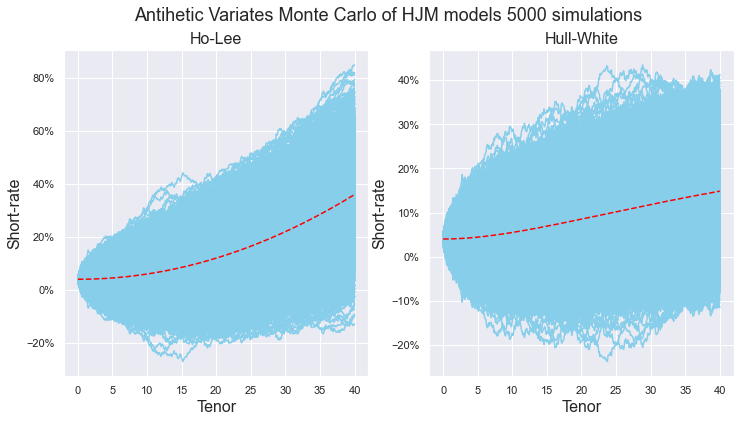

In [5]:
if Npaths <= 10000:
    SR_HL = (Results_HL['SR_u'] + Results_HL['SR_d'])/2
    SR_HW = (Results_HW['SR_u'] + Results_HW['SR_d'])/2

    fig = plt.figure()
    fig.suptitle('Antihetic Variates Monte Carlo of HJM models ' + str(Npaths) + ' simulations' ,fontsize=18)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.set_title('Ho-Lee',fontsize=16)
    ax1.plot(Results_HL['t'], np.transpose(Results_HL['SR_u']), 'skyblue')
    ax1.plot(Results_HL['t'], np.transpose(Results_HL['SR_d']), 'skyblue')
    ax1.plot(Results_HL['t'], np.transpose(SR_HL).mean(axis=1), '--', color='red')
    ax1.set_ylabel("Short-rate", fontsize=16)
    ax1.set_xlabel("Tenor", fontsize=16)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax2.set_title('Hull-White',fontsize=16)
    ax2.plot(Results_HW['t'], np.transpose(Results_HW['SR_u']), 'skyblue')
    ax2.plot(Results_HW['t'], np.transpose(Results_HW['SR_d']), 'skyblue')
    ax2.plot(Results_HW['t'], np.transpose(SR_HW).mean(axis=1), '--', color='red')
    ax2.set_ylabel("Short-rate", fontsize=16)
    ax2.set_xlabel("Tenor", fontsize=16)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.subplots_adjust(hspace=0.01)
    ax2.autoscale()
    plt.show()
else:
    print('Monte Carlo paths plots skipped, input at most 10,000 simulations to show')

In the next plot we can test our no-arbitrage foundation, which tells us that we should be able to recover the Market Prices, while this can be verified easily for low volatility values and high speed reversion, it becomes quickly complicated for the opposite values, rather than this being a contradiction of the HJM framework, it gives us and idea of how fast the models can become unstable, and hence require a significantly bigger number of simulations.

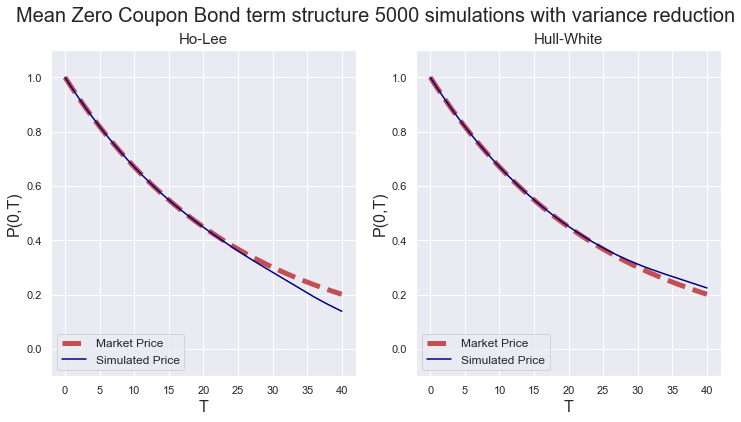

In [6]:
ZCB_HL = (Results_HL['ZCB_u'] + Results_HL['ZCB_d'])/2
ZCB_HW = (Results_HW['ZCB_u'] + Results_HW['ZCB_d'])/2

fig = plt.figure()
fig.suptitle('Mean Zero Coupon Bond term structure '+str(Npaths)+' simulations with variance reduction',fontsize=20)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title('Ho-Lee',fontsize=15)
ax1.plot(Results_HL['t'], Market_Price, '--r', label='Market Price', linewidth=5)
ax1.plot(Results_HL['t'], np.transpose(ZCB_HL).mean(axis=1) ,'navy', label='Simulated Price')
ax1.set_ylabel("P(0,T)", fontsize="16")
ax1.set_xlabel("T", fontsize="16")
ax1.legend(loc='lower left', fontsize=12)
ax1.set_ylim([-0.10, 1.10])

ax2.set_title('Hull-White',fontsize=15)
ax2.plot(Results_HW['t'], Market_Price, '--r', label='Market Price', linewidth=5)
ax2.plot(Results_HW['t'], np.transpose(ZCB_HW).mean(axis=1) ,'navy', label='Simulated Price')
ax2.set_ylabel("P(0,T)", fontsize="16")
ax2.set_xlabel("T", fontsize="16")
ax2.legend(loc='lower left', fontsize=12)
ax2.set_ylim([-0.10, 1.10])

ax1.get_shared_y_axes().join(ax1, ax2)
plt.subplots_adjust(hspace=0.01)
ax2.autoscale()
plt.show()

And finally, we explore how relevant the use of variance reduction techniques can be for this framework, performing a visual inspection tells us that, in this specific case, our convergence does not improve much, which is further evidence of the need of a significant increase of simulations in order to combat the instability caused by bigger parameter values. It is also important to mention that in practice, this parameters are not selected at random, they depend of the use planned by the modeler.

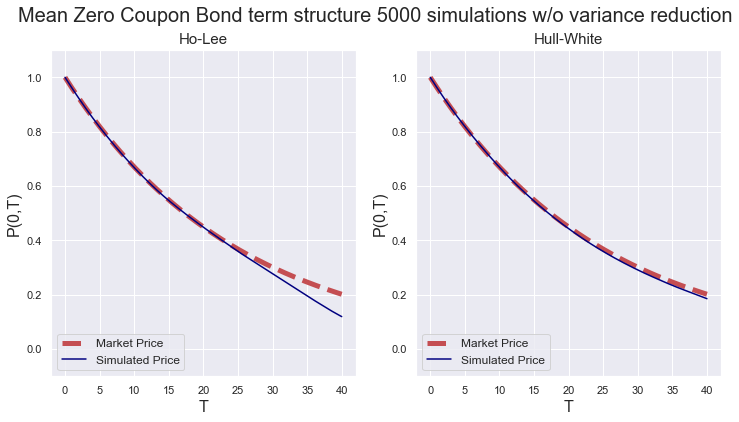

In [7]:
ZCB_HL = Results_HL['ZCB_u']
ZCB_HW = Results_HW['ZCB_u']

fig = plt.figure()
fig.suptitle('Mean Zero Coupon Bond term structure '+str(Npaths)+' simulations w/o variance reduction',fontsize=20)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title('Ho-Lee',fontsize=15)
ax1.plot(Results_HL['t'], Market_Price, '--r', label='Market Price', linewidth=5)
ax1.plot(Results_HL['t'], np.transpose(ZCB_HL).mean(axis=1) ,'navy', label='Simulated Price')
ax1.set_ylabel("P(0,T)", fontsize="16")
ax1.set_xlabel("T", fontsize="16")
ax1.legend(loc='lower left', fontsize=12)
ax1.set_ylim([-0.10, 1.10])

ax2.set_title('Hull-White',fontsize=15)
ax2.plot(Results_HW['t'], Market_Price, '--r', label='Market Price', linewidth=5)
ax2.plot(Results_HW['t'], np.transpose(ZCB_HW).mean(axis=1) ,'navy', label='Simulated Price')
ax2.set_ylabel("P(0,T)", fontsize="16")
ax2.set_xlabel("T", fontsize="16")
ax2.legend(loc='lower left', fontsize=12)
ax2.set_ylim([-0.10, 1.10])

ax1.get_shared_y_axes().join(ax1, ax2)
plt.subplots_adjust(hspace=0.01)
ax2.autoscale()
plt.show()

---- 
## References

This code is based on the excellent material provided at

“Mathematical Modeling and Computation
in Finance: With Exercises and Python and MATLAB Computer Codes”,
by C.W. Oosterlee and L.A. Grzelak, World Scientific Publishing Europe Ltd, 2019.